Generation 0: Best fitness = 3487.818338960049, Spatial error = 241.88775812861311
Generation 1: Best fitness = 3445.0049983080244, Spatial error = 177.85865209739876
Generation 2: Best fitness = 3428.8539365837364, Spatial error = 132.9666043993224
Generation 3: Best fitness = 851.4143706858199, Spatial error = 96.11972390766022
Generation 4: Best fitness = 851.4143706858199, Spatial error = 96.11972390766022
Generation 5: Best fitness = 603.6745885428832, Spatial error = 133.4954511657462
Generation 6: Best fitness = 422.68018302297014, Spatial error = 170.46994336403515
Generation 7: Best fitness = 349.41439089976666, Spatial error = 170.14388334189547
Generation 8: Best fitness = 349.41439089976666, Spatial error = 170.14388334189547
Generation 9: Best fitness = 349.41439089976666, Spatial error = 170.14388334189547
Generation 10: Best fitness = 335.9137949522973, Spatial error = 121.43318520100597
Generation 11: Best fitness = 335.9137949522973, Spatial error = 121.43318520100597


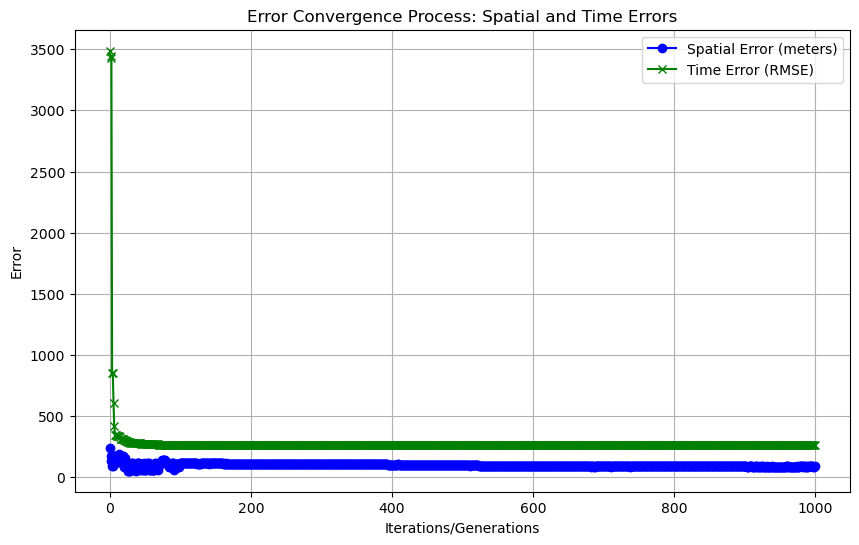

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Constants
sound_speed = 340  # m/s
lat_conversion = 111263  # meters per degree of latitude
lon_conversion = 97304   # meters per degree of longitude

# Device locations (longitude, latitude, height)
device_locations = np.array([
    [110.241, 27.204, 824],
    [110.783, 27.456, 727],
    [110.762, 27.785, 742],
    [110.251, 28.025, 850],
    [110.524, 27.617, 786],
    [110.467, 28.081, 678],
    [110.047, 27.521, 575]
])

# Sound arrival times at each device
sound_times = np.array([
    [100.767, 164.229, 214.850, 270.065],
    [92.453, 112.220, 169.362, 196.583],
    [75.560, 110.696, 156.936, 188.020],
    [94.653, 141.409, 196.517, 258.985],
    [78.600, 86.216, 118.443, 126.669],
    [67.274, 166.270, 175.482, 266.871],
    [103.738, 163.024, 206.789, 210.306]
])

# Convert latitude and longitude to Cartesian coordinates for distance calculation
def lat_lon_to_cartesian(lon, lat, h):
    x = lon * lon_conversion
    y = lat * lat_conversion
    return np.array([x, y, h])

# Calculate the time delay from each device to a potential explosion point using absolute coordinates
def time_delay(device, explosion_point, explosion_time):
    device_cartesian = lat_lon_to_cartesian(*device)
    explosion_cartesian = lat_lon_to_cartesian(*explosion_point)
    distance = np.linalg.norm(device_cartesian - explosion_cartesian)
    time_diff = distance / sound_speed
    return explosion_time + time_diff

# Fitness function: evaluate the total error of the sound arrival times and add penalty for time constraints
def fitness(solution):
    explosion_times = solution[:4]
    explosion_positions = solution[4:].reshape((4, 3))
    
    total_error = 0
    penalty = 0

    # Check the conditions for each explosion time
    for i in range(4):
        # Ensure explosion time is greater than zero
        if explosion_times[i] <= 0:
            penalty += 1000  # Large penalty for negative or zero times
        
        # Ensure explosion time is less than the minimum arrival time for each device
        for j in range(7):
            min_arrival_time = np.min(sound_times[j])
            if explosion_times[i] >= min_arrival_time:
                penalty += 1000  # Large penalty for exceeding the minimum arrival time

    # Calculate RMSE for the sound arrival times
    for i in range(7):  # For each device
        for j in range(4):  # For each explosion
            predicted_time = time_delay(device_locations[i], explosion_positions[j], explosion_times[j])
            total_error += (predicted_time - sound_times[i, j]) ** 2  # Squared error
    
    # Add penalty if the time differences between explosions exceed 5 seconds
    for i in range(4):
        for j in range(i + 1, 4):
            if abs(explosion_times[i] - explosion_times[j]) > 5:
                penalty += 1000  # Arbitrary large penalty value for violation

    return np.sqrt(total_error) + penalty  # RMSE with penalty

# Calculate spatial error: the Euclidean distance between predicted and actual explosion positions
def spatial_error(predicted_positions, true_positions):
    return np.mean([np.linalg.norm(predicted_positions[i] - true_positions[i]) for i in range(4)])

# Initial population generation
def generate_initial_population(pop_size):
    population = []
    for _ in range(pop_size):
        explosion_times = np.random.uniform(1, 200, 4)  # Random initial times, starting from 1 to ensure positive values
        explosion_positions = np.random.uniform([110.0, 27.0, 500], [111.0, 28.0, 900], (4, 3))  # Random positions in lat/lon/altitude
        solution = np.concatenate([explosion_times, explosion_positions.flatten()])
        population.append(solution)
    return population

# Selection, crossover, and mutation operations with elite preservation
def evolve_population(population, elite_size=1, generation_num=1, max_generations=500):
    # Sort population by fitness
    population = sorted(population, key=fitness)
    
    # Elite preservation: retain the best solutions
    new_population = population[:elite_size]
    
    # Adaptive mutation rate
    mutation_rate = max(0.1, 1.0 - (generation_num / max_generations))  # Decaying mutation rate
    
    # Crossover and mutation
    while len(new_population) < len(population):
        parents = random.sample(population[:len(population)//2], 2)  # Select from best half
        cross_point = random.randint(1, len(parents[0]) - 1)
        child = np.concatenate([parents[0][:cross_point], parents[1][cross_point:]])
        
        # Mutation
        if random.random() < mutation_rate:
            mutation_index = random.randint(0, len(child) - 1)
            child[mutation_index] += np.random.uniform(-1, 1)
        
        new_population.append(child)
    
    return new_population

# Genetic algorithm with elite preservation and PSO
def genetic_algorithm_with_pso(pop_size=300, generations=1000, elite_size=5):
    population = generate_initial_population(pop_size)
    space_errors = []  # 用于记录每次迭代中的空间误差
    time_errors = []   # 用于记录每次迭代中的时间误差

    true_positions = np.array([
        [110.432, 27.699, 773],  # 假设的真实残骸位置
        [110.459, 27.665, 562],
        [110.442, 27.710, 458],
        [110.952, 27.591, 789]
    ])

    for generation in range(generations):
        population = evolve_population(population, elite_size, generation, generations)

        # Track the best solution found
        best_solution = min(population, key=fitness)
        best_fitness = fitness(best_solution)
        
        # 记录空间误差（使用真实位置）
        explosion_positions = best_solution[4:].reshape((4, 3))
        space_err = spatial_error(explosion_positions, true_positions)
        space_errors.append(space_err)
        
        # 记录时间误差
        time_errors.append(best_fitness)
        
        print(f"Generation {generation}: Best fitness = {best_fitness}, Spatial error = {space_err}")

        # If fitness is good enough, stop early
        if best_fitness < 100:
            break
    
    return best_solution, space_errors, time_errors

# Run the optimized genetic algorithm with PSO
best_solution, space_errors, time_errors = genetic_algorithm_with_pso()

# Extract the final results
explosion_times = best_solution[:4]
final_positions = best_solution[4:].reshape((4, 3))

# Calculate final error
total_error = fitness(best_solution)

# Output the final explosion times and positions with error
print("Best explosion times:", explosion_times)
print("Best explosion positions (longitude, latitude, height):", final_positions)
print("Total error (RMSE):", total_error)

# 可视化空间和时间误差收敛过程的函数
def visualize_error_convergence(space_errors, time_errors):
    plt.figure(figsize=(10, 6))

    # 绘制空间误差收敛曲线
    plt.plot(space_errors, label='Spatial Error (meters)', marker='o', color='blue')

    # 绘制时间误差收敛曲线
    plt.plot(time_errors, label='Time Error (RMSE)', marker='x', color='green')

    # 设置标签和标题
    plt.xlabel('Iterations/Generations')
    plt.ylabel('Error')
    plt.title('Error Convergence Process: Spatial and Time Errors')
    plt.legend()
    plt.grid(True)
    plt.show()

# 可视化空间和时间误差收敛过程
visualize_error_convergence(space_errors, time_errors)


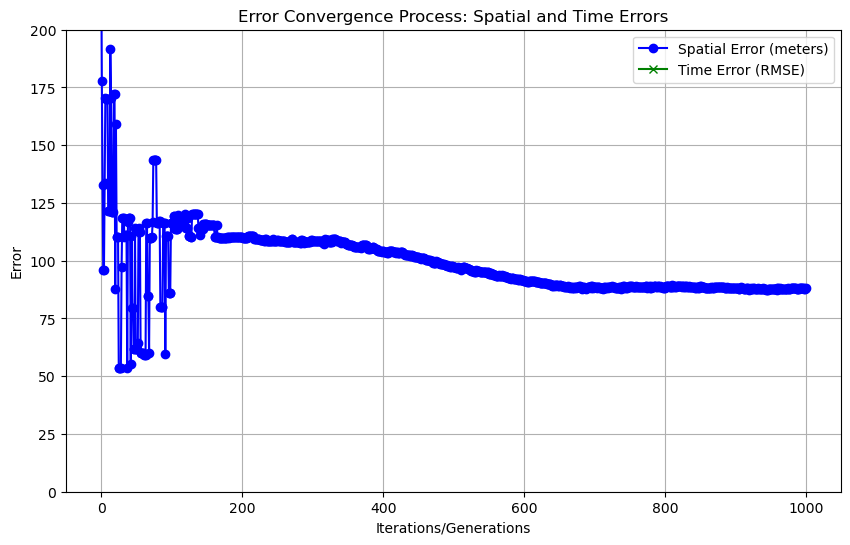

In [3]:
def visualize_error_convergence_scaled(space_errors, time_errors, y_limit=(0, 100)):
    plt.figure(figsize=(10, 6))

    # 绘制空间误差收敛曲线
    plt.plot(space_errors, label='Spatial Error (meters)', marker='o', color='blue')

    # 绘制时间误差收敛曲线
    plt.plot(time_errors, label='Time Error (RMSE)', marker='x', color='green')

    # 设置 y 轴范围
    plt.ylim(y_limit)

    # 设置标签和标题
    plt.xlabel('Iterations/Generations')
    plt.ylabel('Error')
    plt.title('Error Convergence Process: Spatial and Time Errors')
    plt.legend()
    plt.grid(True)
    plt.show()

# 可视化缩放后的空间和时间误差收敛过程
visualize_error_convergence_scaled(space_errors, time_errors, y_limit=(0, 200))


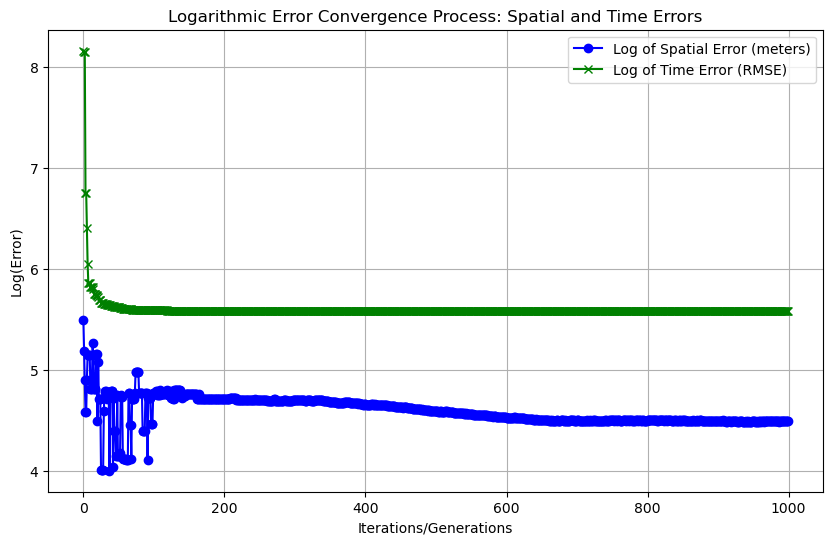

In [5]:
def visualize_error_convergence_log(space_errors, time_errors):
    plt.figure(figsize=(10, 6))

    # 对误差取对数变换，避免 log(0) 的问题
    log_space_errors = np.log1p(space_errors)  # log(1 + error)，避免负值或 log(0) 问题
    log_time_errors = np.log1p(time_errors)

    # 绘制对数变换后的空间误差收敛曲线
    plt.plot(log_space_errors, label='Log of Spatial Error (meters)', marker='o', color='blue')

    # 绘制对数变换后的时间误差收敛曲线
    plt.plot(log_time_errors, label='Log of Time Error (RMSE)', marker='x', color='green')

    # 设置标签和标题
    plt.xlabel('Iterations/Generations')
    plt.ylabel('Log(Error)')
    plt.title('Logarithmic Error Convergence Process: Spatial and Time Errors')
    plt.legend()
    plt.grid(True)
    plt.show()

# 可视化对数变换后的空间和时间误差收敛过程
visualize_error_convergence_log(space_errors, time_errors)
